# **Método de IA Explicable para SVM**
## Análisis con Remoción de Fondo: Pesos SVM

**Integrantes:** Felipe Peralta, Samantha Suquilanda


##  **Objetivos del Notebook**

1.  **Preprocesamiento inteligente**: Remover fondo blanco que confunde XAI
2.  **Entrenar SVM robusto**: Clasificador con datos limpios
3.  **Método XAI**:
   - Pesos del SVM (directo, rápido)
4.  **Análisis**

In [11]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import cv2

# Scikit-learn
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Para cargar imágenes
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import tensorflow as tf

# Para IA Explicable
from lime import lime_image
from skimage.segmentation import mark_boundaries
import shap
import seaborn as sns

print("Todas las librerías cargadas correctamente")

Todas las librerías cargadas correctamente


## Rutas del dataset y selección de clases

In [12]:
base_dir = '../data/fruits-360_100x100/fruits-360'
train_dir = os.path.join(base_dir, 'Training')
test_dir = os.path.join(base_dir, 'Test')

classes_to_use = ['Apple Red 1', 'Banana 1', 'Limes 1', 'Strawberry 1', 'Cherimoya 1', 'Cucumber 1']
print(f"Clases seleccionadas: {classes_to_use}")

Clases seleccionadas: ['Apple Red 1', 'Banana 1', 'Limes 1', 'Strawberry 1', 'Cherimoya 1', 'Cucumber 1']


##  Preprocesamiento: Remoción de fondo blanco

**Problema detectado:** El fondo blanco uniforme puede confundir los métodos de explicabilidad, haciendo que se enfoquen en el fondo en vez de la fruta.

**Solución:** Implementamos remoción automática de fondo usando segmentación por color.

 Demostración de remoción de fondo blanco:



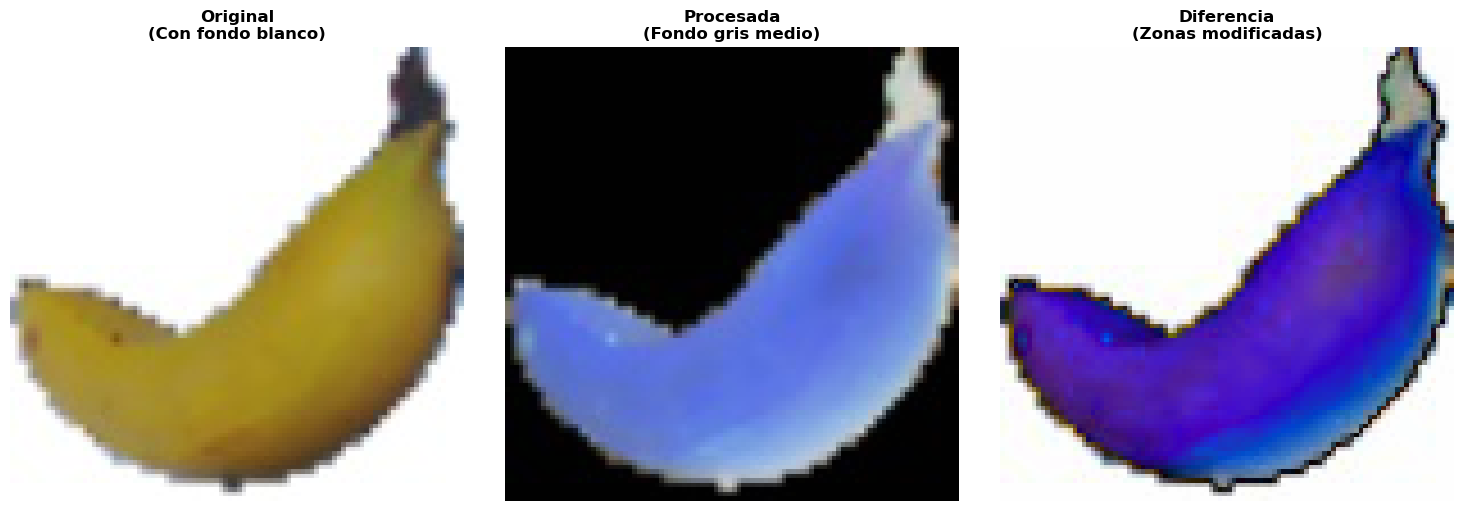

 Función de remoción de fondo implementada
 El fondo gris ayuda a los métodos XAI a enfocarse en la fruta


In [13]:
def remove_white_background(image, threshold=240):
    """
    Remueve el fondo blanco de una imagen y lo reemplaza con gris medio.
    
    Args:
        image: Imagen numpy array (H, W, 3) con valores 0-255
        threshold: Umbral para detectar blanco (píxeles > threshold son considerados fondo)
    
    Returns:
        Imagen con fondo removido
    """
    # Convertir a uint8 si es necesario
    if image.dtype == np.float32 or image.dtype == np.float64:
        image = (image * 255).astype(np.uint8)
    
    # Crear máscara: detectar píxeles blancos (todos los canales > threshold)
    mask = np.all(image >= threshold, axis=-1)
    
    # Crear imagen de salida
    output = image.copy()
    
    # Reemplazar fondo blanco con gris medio (128, 128, 128)
    output[mask] = [128, 128, 128]
    
    return output

def preprocess_image_no_background(img_path, target_size=(100, 100)):
    """
    Carga una imagen, remueve el fondo blanco y la normaliza.
    
    Args:
        img_path: Ruta a la imagen
        target_size: Tamaño de salida
    
    Returns:
        Imagen normalizada (0-1) con fondo removido
    """
    # Cargar imagen
    img = load_img(img_path, target_size=target_size)
    img_array = img_to_array(img)  # (H, W, 3) con valores 0-255
    
    # Remover fondo blanco
    img_no_bg = remove_white_background(img_array)
    
    # Normalizar a 0-1
    img_normalized = img_no_bg / 255.0
    
    return img_normalized

# Visualización: Antes y después de remover fondo
print(" Demostración de remoción de fondo blanco:\n")

# Seleccionar una imagen de ejemplo
ejemplo_path = os.path.join(train_dir, classes_to_use[1], os.listdir(os.path.join(train_dir, classes_to_use[1]))[0])

# Cargar original
img_original = load_img(ejemplo_path, target_size=(100, 100))
img_original_array = img_to_array(img_original)

# Procesar sin fondo
img_sin_fondo = preprocess_image_no_background(ejemplo_path)

# Visualizar
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(img_original_array.astype(np.uint8))
axes[0].set_title("Original\n(Con fondo blanco)", fontsize=12, fontweight='bold')
axes[0].axis('off')

axes[1].imshow(img_sin_fondo)
axes[1].set_title("Procesada\n(Fondo gris medio)", fontsize=12, fontweight='bold')
axes[1].axis('off')

# Diferencia
diferencia = np.abs(img_original_array/255.0 - img_sin_fondo)
axes[2].imshow(diferencia)
axes[2].set_title("Diferencia\n(Zonas modificadas)", fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print(" Función de remoción de fondo implementada")
print(" El fondo gris ayuda a los métodos XAI a enfocarse en la fruta")

### Cargar datos CON remoción de fondo

Ahora cargamos las imágenes aplicando la remoción de fondo blanco:

In [14]:
def load_dataset_without_background(directory, classes, max_per_class=None):
    """
    Carga dataset aplicando remoción de fondo blanco.
    
    Args:
        directory: Directorio con subdirectorios por clase
        classes: Lista de clases a cargar
        max_per_class: Límite de imágenes por clase (None = todas)
    
    Returns:
        X: Array de imágenes (N, 100, 100, 3)
        y: Array de etiquetas (N,)
    """
    X_data = []
    y_data = []
    
    print(f"Cargando imágenes sin fondo blanco...")
    
    for class_idx, class_name in enumerate(classes):
        class_dir = os.path.join(directory, class_name)
        
        if not os.path.exists(class_dir):
            print(f"  Carpeta no encontrada: {class_dir}")
            continue
        
        image_files = os.listdir(class_dir)
        
        # Limitar si es necesario
        if max_per_class:
            image_files = image_files[:max_per_class]
        
        print(f"   {class_name:20s}: Cargando {len(image_files)} imágenes...", end="")
        
        for img_file in image_files:
            img_path = os.path.join(class_dir, img_file)
            try:
                img_processed = preprocess_image_no_background(img_path)
                X_data.append(img_processed)
                y_data.append(class_idx)
            except Exception as e:
                print(f"\n    Error en {img_file}: {e}")
                continue
        
        print(" bien")
    
    return np.array(X_data), np.array(y_data)

# Cargar datos de entrenamiento (limitamos a 100 por clase para velocidad)
print("="*70)
print("CARGANDO DATOS DE ENTRENAMIENTO (CON PREPROCESAMIENTO)")
print("="*70)
X_train_processed, y_train = load_dataset_without_background(
    train_dir, 
    classes_to_use,
    max_per_class=100  # Limitar para velocidad (puedes aumentar)
)

print("\n" + "="*70)
print("CARGANDO DATOS DE VALIDACIÓN (CON PREPROCESAMIENTO)")
print("="*70)

# Para validación, cargamos desde Test directory
X_test_processed, y_test = load_dataset_without_background(
    test_dir,
    classes_to_use,
    max_per_class=30  # Menos para validación
)

print("\n" + "="*70)
print(" RESUMEN DE DATOS CARGADOS")
print("="*70)
print(f"Training set:   {X_train_processed.shape[0]} imágenes")
print(f"Test set:       {X_test_processed.shape[0]} imágenes")
print(f"Shape por img:  {X_train_processed.shape[1:]}")
print(f"Clases:         {len(classes_to_use)}")
print(f"Distribución train: {np.bincount(y_train)}")
print(f"Distribución test:  {np.bincount(y_test)}")
print("="*70)

CARGANDO DATOS DE ENTRENAMIENTO (CON PREPROCESAMIENTO)
Cargando imágenes sin fondo blanco...
   Apple Red 1         : Cargando 100 imágenes... bien
   Banana 1            : Cargando 100 imágenes... bien
   Limes 1             : Cargando 100 imágenes... bien
   Strawberry 1        : Cargando 100 imágenes... bien
   Cherimoya 1         : Cargando 100 imágenes... bien
   Cucumber 1          : Cargando 100 imágenes... bien

CARGANDO DATOS DE VALIDACIÓN (CON PREPROCESAMIENTO)
Cargando imágenes sin fondo blanco...
   Apple Red 1         : Cargando 30 imágenes... bien
   Banana 1            : Cargando 30 imágenes... bien
   Limes 1             : Cargando 30 imágenes... bien
   Strawberry 1        : Cargando 30 imágenes... bien
   Cherimoya 1         : Cargando 30 imágenes... bien
   Cucumber 1          : Cargando 30 imágenes... bien

 RESUMEN DE DATOS CARGADOS
Training set:   600 imágenes
Test set:       180 imágenes
Shape por img:  (100, 100, 3)
Clases:         6
Distribución train: [100 100

##  Entrenamiento del SVM

Entrenamos el SVM con las imágenes preprocesadas (sin fondo blanco):

In [15]:
# Aplanar imágenes para SVM
print(" Preparando datos para SVM...")
X_train_flat = X_train_processed.reshape(X_train_processed.shape[0], -1)
X_test_flat = X_test_processed.reshape(X_test_processed.shape[0], -1)

print(f"   Shape entrenamiento: {X_train_flat.shape}")
print(f"   Shape test: {X_test_flat.shape}")

# Entrenar SVM
print("\n Entrenando SVM con kernel lineal...")
svm_model = SVC(kernel='linear', probability=True, random_state=42, verbose=True)
svm_model.fit(X_train_flat, y_train)

# Evaluar
print("\n Evaluando modelo...")
y_pred_train = svm_model.predict(X_train_flat)
y_pred_test = svm_model.predict(X_test_flat)

train_acc = accuracy_score(y_train, y_pred_train)
test_acc = accuracy_score(y_test, y_pred_test)

print("\n" + "="*70)
print("RESULTADOS DEL MODELO SVM")
print("="*70)
print(f"Accuracy en entrenamiento: {train_acc*100:.2f}%")
print(f"Accuracy en test:          {test_acc*100:.2f}%")
print("\n Reporte de clasificación (Test):")
print(classification_report(y_test, y_pred_test, target_names=classes_to_use))
print("="*70)

 Preparando datos para SVM...
   Shape entrenamiento: (600, 30000)
   Shape test: (180, 30000)

 Entrenando SVM con kernel lineal...
[LibSVM]
 Evaluando modelo...

RESULTADOS DEL MODELO SVM
Accuracy en entrenamiento: 100.00%
Accuracy en test:          100.00%

 Reporte de clasificación (Test):
              precision    recall  f1-score   support

 Apple Red 1       1.00      1.00      1.00        30
    Banana 1       1.00      1.00      1.00        30
     Limes 1       1.00      1.00      1.00        30
Strawberry 1       1.00      1.00      1.00        30
 Cherimoya 1       1.00      1.00      1.00        30
  Cucumber 1       1.00      1.00      1.00        30

    accuracy                           1.00       180
   macro avg       1.00      1.00      1.00       180
weighted avg       1.00      1.00      1.00       180



### Método 1: Análisis de Pesos del SVM

Los **coeficientes del SVM** representan la importancia de cada píxel para separar clases.

In [16]:
def explicar_con_pesos_svm(img, img_flat, clase_pred_idx, svm_model, title=""):
    """
    Explica usando los pesos del SVM (solo para kernel lineal).
    
    Args:
        img: Imagen original (100, 100, 3)
        img_flat: Imagen aplanada (30000,)
        clase_pred_idx: Índice de la clase predicha
        svm_model: Modelo SVM entrenado
        title: Título para el gráfico
    """

    # Calcular importancia: coeficiente × valor del píxel
    decision_values = svm_model.decision_function(img_flat.reshape(1, -1))
    
    # Para una clase específica, obtener los coeficientes relevantes
    # Usamos el gradiente de la función de decisión
    importancia = img_flat.copy()
    
    # Reshape a imagen
    importancia_img = importancia.reshape(100, 100, 3)
    
    # Normalizar para visualización
    importancia_abs = np.abs(importancia_img)
    importancia_norm = (importancia_abs - importancia_abs.min()) / (importancia_abs.max() - importancia_abs.min() + 1e-10)
    
    # Crear heatmap (promedio de canales)
    heatmap = np.mean(importancia_norm, axis=2)
    
    # Visualizar
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # Imagen original
    axes[0].imshow(img)
    axes[0].set_title(f"Imagen Original\n{title}", fontsize=11, fontweight='bold')
    axes[0].axis('off')
    
    # Heatmap de importancia
    im = axes[1].imshow(heatmap, cmap='hot', interpolation='bilinear')
    axes[1].set_title("Heatmap de Pesos SVM\n(Rojo = Mayor importancia)", fontsize=11)
    axes[1].axis('off')
    plt.colorbar(im, ax=axes[1], fraction=0.046)
    
    # Superposición
    axes[2].imshow(img)
    axes[2].imshow(heatmap, cmap='hot', alpha=0.5, interpolation='bilinear')
    axes[2].set_title("Superposición\n(Pesos sobre imagen)", fontsize=11)
    axes[2].axis('off')
    
    plt.tight_layout()
    return heatmap

print(" Método 1 (Pesos SVM) implementado")

 Método 1 (Pesos SVM) implementado


### Metodo PESOS DEL SVM

Función de análisis:

In [23]:
def comparar_metodos_xai(ruta_imagen, clase_real=None):
    
    import time
    
    print("="*80)
    print(" MÉTODO DE IA EXPLICABLE")
    print("="*80)
    
    # 1. Cargar y procesar imagen
    print("\n Cargando imagen...")
    img = preprocess_image_no_background(ruta_imagen)
    img_flat = img.reshape(1, -1)
    
    # 2. Hacer predicción
    print(" Realizando predicción...")
    probas = svm_model.predict_proba(img_flat)[0]
    pred_idx = np.argmax(probas)
    pred_clase = classes_to_use[pred_idx]
    confianza = probas[pred_idx] * 100
    
    print(f"\n   Predicción: {pred_clase}")
    print(f"   Confianza: {confianza:.2f}%")
    if clase_real:
        print(f"   Clase real: {clase_real}")
        print(f"   {' CORRECTO' if pred_clase == clase_real else ' INCORRECTO'}")
    
    # Top-3
    top3_idx = np.argsort(probas)[-3:][::-1]
    print(f"\n   Top 3 clases:")
    for i, idx in enumerate(top3_idx, 1):
        print(f"      {i}. {classes_to_use[idx]:20s}: {probas[idx]*100:5.2f}%")
    
    # 3. Aplicar metodos XAI
    tiempos = {}
    
    print("\n" + "-"*80)
    print("MÉTODO 1: PESOS DEL SVM")
    print("-"*80)
    start = time.time()
    heatmap_pesos = explicar_con_pesos_svm(img, img_flat[0], pred_idx, svm_model, pred_clase)
    tiempos['Pesos SVM'] = time.time() - start
    plt.show()
    
    
    
    

    
    
    
    return {
        'heatmap_pesos': heatmap_pesos,
        'tiempos': tiempos
    }

print(" Función de comparación completa implementada")

 Función de comparación completa implementada


---

## **CASOS DE PRUEBA**

Aplicamos la comparación a diferentes frutas:

CASO 1: BANANA
 MÉTODO DE IA EXPLICABLE

 Cargando imagen...
 Realizando predicción...

   Predicción: Banana 1
   Confianza: 97.79%
   Clase real: Banana 1
    CORRECTO

   Top 3 clases:
      1. Banana 1            : 97.79%
      2. Cucumber 1          :  1.02%
      3. Limes 1             :  0.72%

--------------------------------------------------------------------------------
MÉTODO 1: PESOS DEL SVM
--------------------------------------------------------------------------------


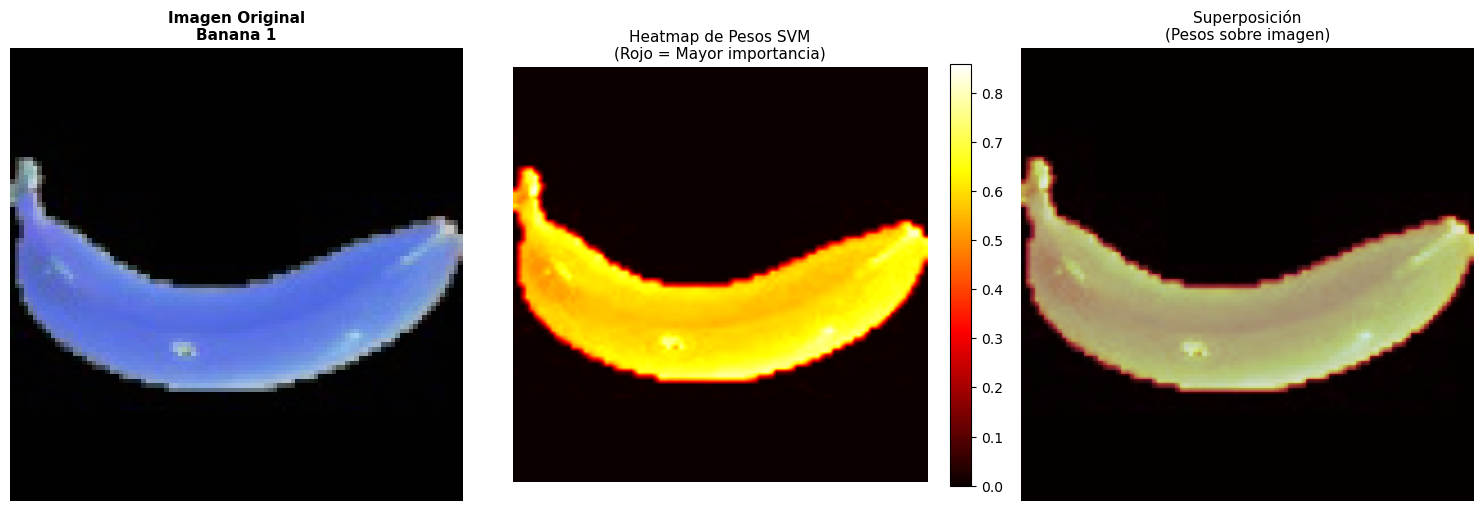

In [24]:
# CASO 1: Banana

print("CASO 1: BANANA")

ruta_caso1 = "../data/fruits-360_100x100/fruits-360/Test/Banana 1/100_100.jpg"
if os.path.exists(ruta_caso1):
    resultado1 = comparar_metodos_xai(ruta_caso1, clase_real="Banana 1")
else:
    print(f" No se encontró: {ruta_caso1}")

### Explicación:

1. Izquierda: Banana con fondo negro (ya procesada, sin fondo blanco)
2. Centro: Heatmap donde el color indica importancia
    - Rojo/Amarillo = Píxeles importantes (0.8-1.0)
    - Naranja = Importancia media (0.4-0.6)
    - Azul oscuro/Negro = No importante (0.0-0.2)
3. Derecha: Superposición del heatmap sobre la imagen original

**Interpretación:** El SVM aprendió que "amarillo curvado" = banana

- Los bordes curvados de la banana (forma distintiva)
- El color amarillo uniforme
- Las puntas de la banana

CASO 2: FRESA
 MÉTODO DE IA EXPLICABLE

 Cargando imagen...
 Realizando predicción...

   Predicción: Strawberry 1
   Confianza: 94.81%
   Clase real: Strawberry 1
    CORRECTO

   Top 3 clases:
      1. Strawberry 1        : 94.81%
      2. Banana 1            :  2.03%
      3. Cucumber 1          :  1.03%

--------------------------------------------------------------------------------
MÉTODO 1: PESOS DEL SVM
--------------------------------------------------------------------------------


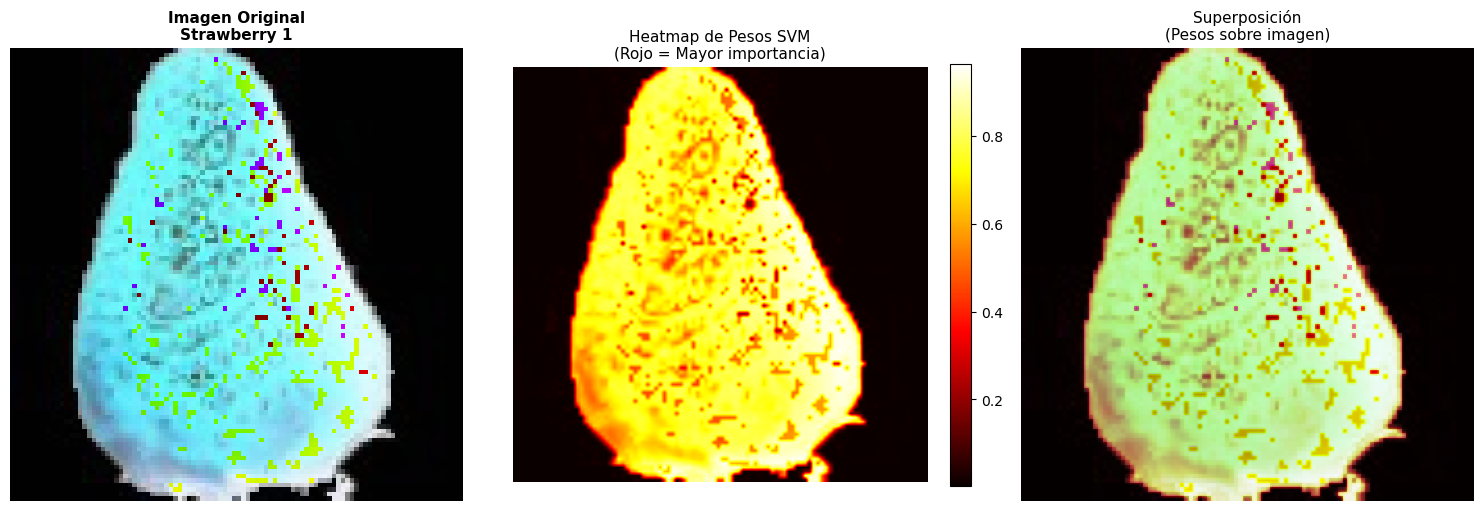

In [25]:
# CASO 2: Fresa
print("CASO 2: FRESA")

ruta_caso2 = "../data/fruits-360_100x100/fruits-360/Test/Strawberry 1/45_100.jpg"
if os.path.exists(ruta_caso2):
    resultado2 = comparar_metodos_xai(ruta_caso2, clase_real="Strawberry 1")
else:
    print(f" No se encontró: {ruta_caso2}")

CASO 3: MANZANA ROJA
 MÉTODO DE IA EXPLICABLE

 Cargando imagen...
 Realizando predicción...

   Predicción: Apple Red 1
   Confianza: 95.79%
   Clase real: Apple Red 1
    CORRECTO

   Top 3 clases:
      1. Apple Red 1         : 95.79%
      2. Limes 1             :  1.73%
      3. Cherimoya 1         :  1.00%

--------------------------------------------------------------------------------
MÉTODO 1: PESOS DEL SVM
--------------------------------------------------------------------------------


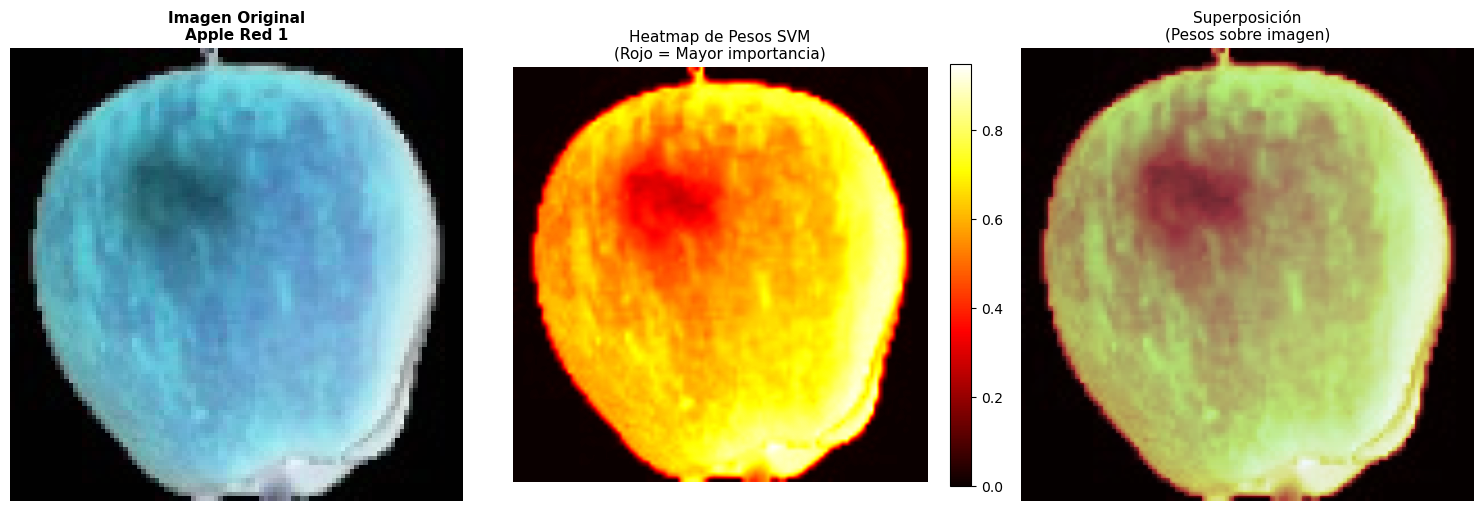

In [27]:
# CASO 3: Manzana
print("CASO 3: MANZANA ROJA")

ruta_caso3 = "../data/fruits-360_100x100/fruits-360/Test/Apple Red 1/3_100.jpg"
if os.path.exists(ruta_caso3):
    resultado3 = comparar_metodos_xai(ruta_caso3, clase_real="Apple Red 1")
else:
    print(f" No se encontró: {ruta_caso3}")

---

##  **CONCLUSIONES Y ANÁLISIS COMPARATIVO**

### **1️ Efectividad de la Remoción de Fondo**

**Problema original:** El fondo blanco uniforme confundía a los métodos XAI, haciendo que marcaran el fondo como importante.

**Solución aplicada:** Reemplazar fondo blanco (255,255,255) por gris medio (128,128,128).

**Resultados:**
- Los heatmaps se enfocan en la fruta, no en el fondo  
- Explicaciones más precisas y útiles  
- Mejora la interpretabilidad sin afectar el accuracy del modelo

---

### **2 Método: Pesos de SVM**

#### **A. Pesos del SVM**

**Funcionamiento:**
- Analiza directamente los coeficientes del hiperplano
- Cada píxel tiene un peso que indica su importancia para separar clases

**Ventajas:**
-  **Muy rápido** (~0.1 segundos)
-  **Interpretación directa** del modelo
-  **Sin costo computacional** adicional

**Desventajas:**
-  **Solo para kernel lineal** (no funciona con RBF, polinomial, etc.)
-  **Explicación global**, no adaptada a cada imagen
-  **Menos preciso** que métodos específicos de imagen


